In [1]:
import pandas as pd
import numpy as np
import os
from functools import reduce

from matplotlib import pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter, EngFormatter

from gini import gini

In [2]:
[blue, orange, green, red, purple, brown] = sns.color_palette()[:6]

# Measuring Statistical Dispersion with the Gini Coefficient

_Kimberly Fessel, PhD_ &nbsp; ||  &nbsp; _05 June 2020_  &nbsp; || &nbsp;  [Full Blog Post](http://kimberlyfessel.com/mathematics/applications/gini-use-cases/)

## Case \#1: Baby Names 

Begin by loading the baby names from the US [Social Security Administration](https://www.ssa.gov/oact/babynames/limits.html) and filtering to 1950 through 2018.

In [3]:
names_dir = 'data/namesbystate/'
names_data_list = []
names_columns = ['state', 'gender', 'year', 'name', 'babies']

for file in os.listdir(names_dir):
    if file.endswith(".TXT"):
        names_data = pd.read_csv(names_dir + file, header=None, names=names_columns)
        names_data_list.append(names_data)
    else:
        continue

names_data = pd.concat(names_data_list)

In [4]:
data = names_data[names_data.year >= 1950]

Higher proportion of male babies registered with Social Security Administration

In [5]:
data.groupby('gender').babies.sum() / data.babies.sum()

gender
F    0.470069
M    0.529931
Name: babies, dtype: float64

In [6]:
total_babies = data.babies.sum()
female_perc = data[data.gender=='F'].babies.sum() / total_babies
male_perc = data[data.gender=='M'].babies.sum() / total_babies

### Most Popular Names

Check most popular names by gender -- 18 out of top 20 names more commonly given to males.

In [7]:
most_popular_names = (
    data
    .groupby(['name', 'gender'])
    .babies
    .sum()
    .reset_index()
    .sort_values('babies', ascending=False)
)

In [8]:
most_popular_names[:20]   

,name,gender,babies
20839,Michael,M,3888725
7201,David,M,2874196
12793,James,M,2863869
14233,John,M,2729816
24549,Robert,M,2569730
30104,William,M,2102417
5929,Christopher,M,2004215
14474,Joseph,M,1688940
6899,Daniel,M,1674697
20297,Matthew,M,1567222


"Michael" represents over 3% of male babies in the data.

In [9]:
(
    most_popular_names[
        (most_popular_names['name'] == 'Michael') &
        (most_popular_names['gender'] == 'M')
    ].babies 
    / most_popular_names[
        most_popular_names['gender']=='M'
    ].babies
    .sum()
)

20839    0.032098
Name: babies, dtype: float64

### Unique Names by Gender

Calculate and plot number of unique names per gender over time.

In [10]:
unique_names_per_gender = (
    data
    .groupby(['year', 'gender'])
    .name
    .nunique()
    .unstack()
)

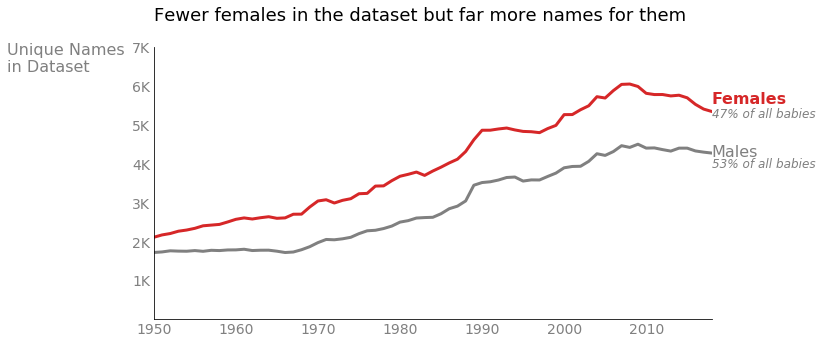

In [11]:
fig, ax = plt.subplots(1, 1)
unique_names_per_gender.plot(figsize=(10,5), ax=ax, linewidth=3, color=[red, 'gray'])
plt.xlabel('')
plt.ylabel('Unique Names\nin Dataset', 
           fontsize=16, 
           color='gray', 
           rotation = 0,
           horizontalalignment='left',
           labelpad=125,
           position=(-.1, .9))
plt.legend([], frameon=False)
plt.title('Fewer females in the dataset but far more names for them\n', loc='left', fontsize=18)
plt.ylim(0, 6500)

#Annotate
plt.text(2018, 5550, 'Females', color=red, fontsize=16, fontweight='bold')
plt.text(2018, 5200, '{:.0f}% of all babies'.format(female_perc*100), color='gray', fontsize=12, fontstyle='italic')
plt.text(2018, 4200, 'Males', color='gray', fontsize=16 )
plt.text(2018, 3900, '{:.0f}% of all babies'.format(male_perc*100), color='gray', fontsize=12, fontstyle='italic')

#Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

g = ax.get_yticks()
plt.yticks(g[1:])
ax.tick_params(axis='both', which='major', colors='gray', labelsize=14, length=0)

ax.get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(str(int(x/1000))+'K')))

### Overall Gini Coefficients per Gender

Calculate the overall Gini coefficient for each gender.

In [12]:
gini_gender = (
    most_popular_names
    .groupby('gender')
    .babies
    .apply(lambda x: gini(np.array(x.astype('float'))))
)

gini_gender

gender
F    0.956617
M    0.966787
Name: babies, dtype: float64

Some female names appear only five times in the entire dataset.  "Jennifer" represents roughly 1.5 million babies.

In [13]:
female_babies = (
    most_popular_names[most_popular_names.gender=='F']
    .sort_values(['babies', 'name'])
)

male_babies = (
    most_popular_names[most_popular_names.gender=='M']
    .sort_values(['babies', 'name'])
)

In [14]:
female_babies.head()

,name,gender,babies
24,Aalaya,F,5
35,Aalliyah,F,5
38,Aamani,F,5
44,Aamori,F,5
50,Aanshi,F,5


In [15]:
female_babies.tail()

,name,gender,babies
18520,Lisa,F,960765
13919,Jessica,F,1041256
8961,Elizabeth,F,1068264
20166,Mary,F,1347816
13711,Jennifer,F,1455716


Build plot for male and female Lorenz curves.  (Did not appear in blog post.)

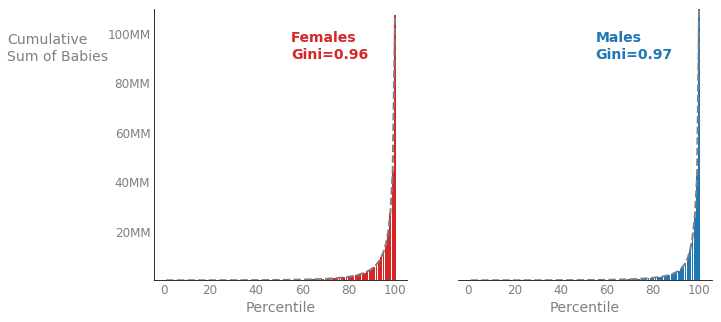

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

#Females
ax[0].bar(range(1, 101), 
        [np.percentile(female_babies.babies.cumsum(), i) for i in range(1, 101)],
        color = red
      )
ax[0].plot(range(1, 101), 
        [np.percentile(female_babies.babies.cumsum(), i) for i in range(1, 101)],
        color = 'gray',
        lw=2,
        linestyle='--'
      )
ax[0].set_xlabel('Percentile',
           fontsize=14,
           color='gray'
          )
ax[0].set_ylabel('Cumulative\nSum of Babies', 
           fontsize=14, 
           color='gray', 
           rotation = 0,
           horizontalalignment='left',
           labelpad=100,
           position=(-.5, .8))
ax[0].set_ylim(0, 110000000)

#Annotate
ax[0].text(55, 90000000, 'Females\nGini=0.96', color=red, fontsize=14, fontweight='bold')

#Style
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)

g = ax[0].get_yticks()
ax[0].set_yticks(g[1:-1])
ax[0].tick_params(axis='both', which='major', colors='gray', labelsize=12, length=0)

ax[0].get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(str(int(x/1000000))+'MM')))


#Males
ax[1].bar(range(1, 101), 
        [np.percentile(male_babies.babies.cumsum(), i) for i in range(1, 101)],
        color = blue
      )
ax[1].plot(range(1, 101), 
        [np.percentile(male_babies.babies.cumsum(), i) for i in range(1, 101)],
        color = 'gray',
        lw=2,
        linestyle='--'
      )
ax[1].set_xlabel('Percentile',
           fontsize=14,
           color='gray'
          )
ax[1].set_ylim(0, 110000000)
ax[1].set_yticks([])

#Annotate
ax[1].text(55, 90000000, 'Males\nGini=0.97', color=blue, fontsize=14, fontweight='bold')

#Style
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)

ax[1].tick_params(axis='both', which='major', colors='gray', labelsize=12, length=0)

### Gini Coefficient per Gender Over Time

Create dataframe of baby counts per name per gender per year.

In [17]:
data_gender_year = data.groupby(['gender', 'year', 'name'], as_index=False).babies.sum()

In [18]:
data_gender_year[:10]

,gender,year,name,babies
0,F,1950,Abbe,5
1,F,1950,Abbie,29
2,F,1950,Abby,42
3,F,1950,Abelina,9
4,F,1950,Abigail,53
5,F,1950,Ada,436
6,F,1950,Addie,206
7,F,1950,Adela,99
8,F,1950,Adelaida,15
9,F,1950,Adelaide,35


Calculate and plot Gini coefficients for each gender for each year.

In [19]:
yearly_gini = (
    data_gender_year
    .groupby(['gender', 'year'])
    .babies
    .apply(lambda x: gini(np.array(x.astype('float'))))
)

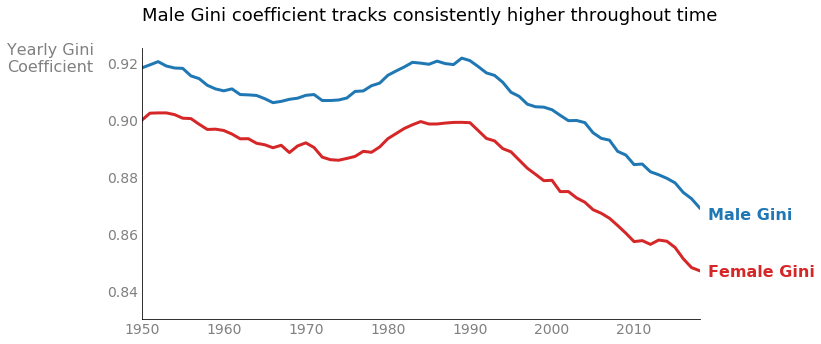

In [20]:
fig, ax = plt.subplots(1, 1)

yearly_gini.unstack().T.plot(figsize=(10, 5), ax=ax, linewidth=3, color=[red, blue])
plt.xlabel('')
plt.ylabel('Yearly Gini\nCoefficient', 
           fontsize=16, 
           color='gray', 
           rotation = 0,
           horizontalalignment='left',
           labelpad=100,
           position=(-.1, .9))
plt.legend([], frameon=False)
plt.title('Male Gini coefficient tracks consistently higher throughout time\n', 
          loc='left', fontsize=18)
plt.ylim(0.83, None)

#Annotate
plt.text(2019, .845, 'Female Gini', color=red, fontsize=16, fontweight='bold')
plt.text(2019, .865, 'Male Gini', color=blue, fontsize=16, fontweight='bold' )

#Style
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='both', which='major', colors='gray', labelsize=14, length=0)

### Popularity Shifts of Female Names: Miriam vs Scarlett

Count number of years each female name appears.

In [21]:
data_females_year = data_gender_year[data_gender_year.gender=='F']

In [22]:
data_females_year['year_count'] = (data_females_year
                                    .groupby('name')
                                    .year
                                    .transform('count'))

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [23]:
data_females_year.head()

,gender,year,name,babies,year_count
0,F,1950,Abbe,5,24
1,F,1950,Abbie,29,67
2,F,1950,Abby,42,69
3,F,1950,Abelina,9,11
4,F,1950,Abigail,53,69


Detect popularity shifts with Gini applied to the yearly data for each name.  

Restrict to only names that have appeared in at least 30 years to avoid spurious results.

In [24]:
gini_fem_names = (
    data_females_year[data_females_year.year_count >= 30]
    .groupby(['name'])
    .babies
    .apply(lambda x: gini(np.array(x.astype('float'))))
    .sort_values()
)

"Miriam" is the most steady name throughout the years.

In [25]:
gini_fem_names.head(15)

name
Miriam       0.119885
Adilene      0.122015
Blimie       0.122057
Elizabeth    0.123239
Nina         0.124333
Danny        0.124542
Lea          0.127599
Elisa        0.143393
Madelene     0.145471
Grecia       0.146957
Estela       0.147354
Antonia      0.149523
Maria        0.152434
Celinda      0.152792
Susanna      0.152862
Name: babies, dtype: float64

"Scarlett" experienced the second largest popularity shifts.

In [26]:
gini_fem_names.tail(15)

name
Debbie      0.769605
Vivienne    0.770744
Magnolia    0.771646
Gemma       0.772434
Bella       0.781660
Piper       0.783383
Raelynn     0.784438
Aria        0.787152
Sheena      0.797374
Mila        0.798348
Adeline     0.798906
Katina      0.801764
Zina        0.802010
Scarlett    0.803179
Nova        0.862324
Name: babies, dtype: float64

Create plot to compare "Miriam" vs "Scarlett" popularity, Lorenz curves, and Gini coefficients.

In [27]:
def get_females(name, var):
    return data_females_year[data_females_year.name == name][var]

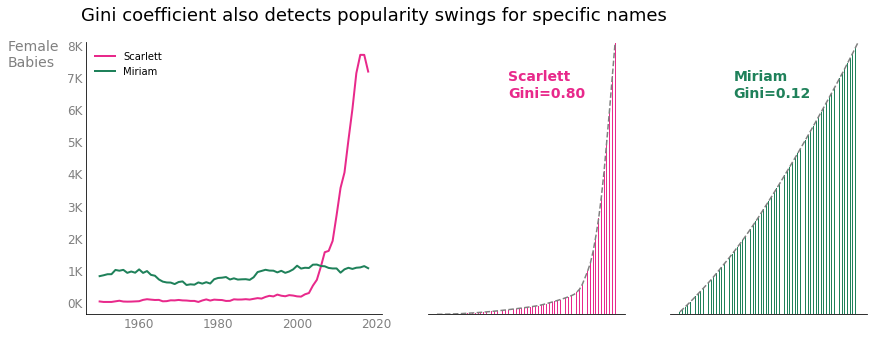

In [28]:
scarlett_color = '#E8298B'
miriam_color = '#1F815A'

fig, ax = plt.subplots(1, 3, figsize=(14, 5), gridspec_kw={'width_ratios': [1.5, 1, 1]})

#Popularity plot
ax[0].plot(get_females('Scarlett', 'year'), get_females('Scarlett', 'babies'), lw=2, color=scarlett_color)
ax[0].plot(get_females('Miriam', 'year'), get_females('Miriam', 'babies'), lw=2, color=miriam_color)

plt.ylim(0, None)
plt.xlabel('')
ax[0].set_ylabel('Female\nBabies', 
           fontsize=14, 
           color='gray', 
           rotation = 0,
           horizontalalignment='left',
           labelpad=60,
           position=(-.1, .9))
ax[0].legend(['Scarlett','Miriam'], frameon=False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
g = ax[0].get_yticks()
ax[0].tick_params(axis='both', which='major', colors='gray', labelsize=12, length=0)
ax[0].get_yaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(str(int(x/1000))+'K')))
ax[0].set_xticks([1960, 1980, 2000, 2020])

#Scarlett Lorenz curve
ax[1].bar(np.linspace(0, 1, len(get_females('Scarlett', 'babies'))), 
           np.cumsum(get_females('Scarlett', 'babies').sort_values()/get_females('Scarlett', 'babies').sum()).get_values(),
           color = scarlett_color,
          width = 0.005
         )
ax[1].plot(np.linspace(0, 1, len(get_females('Scarlett', 'babies'))), 
           np.cumsum(get_females('Scarlett', 'babies').sort_values()/get_females('Scarlett', 'babies').sum()).get_values(),
        color = 'gray',
        linestyle='--'
      )
ax[1].set_ylim((0, 1))
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['left'].set_visible(False)
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].text(.4, .8, 'Scarlett\nGini=0.80', color=scarlett_color, fontsize=14, fontweight='bold')

#Miriam Lorenz curve
ax[2].bar(np.linspace(0, 1, len(get_females('Miriam', 'babies'))), 
           np.cumsum(get_females('Miriam', 'babies').sort_values()/get_females('Miriam', 'babies').sum()).get_values(),
        color = miriam_color, width=0.005
      )
ax[2].plot(np.linspace(0, 1, len(get_females('Miriam', 'babies'))), 
           np.cumsum(get_females('Miriam', 'babies').sort_values()/get_females('Miriam', 'babies').sum()).get_values(),
        color = 'gray',
        linestyle='--'
      )
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].spines['left'].set_visible(False)
ax[2].set_xticks([])
ax[2].set_yticks([])
ax[2].text(.3, .8, 'Miriam\nGini=0.12', color=miriam_color, fontsize=14, fontweight='bold')

#Title
plt.suptitle('Gini coefficient also detects popularity swings for specific names\n',
            x=.41, fontsize=18);

Both names represent roughly 60,000 babies in the dataset.

In [29]:
get_females('Scarlett', 'babies').sum()

63035

In [30]:
get_females('Miriam', 'babies').sum()

60255

# Case \#2: Healthcare Prices

Load data from the [Centers for Medicare and Medicaid Services](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Inpatient2017). _(Data not hosted on GitHub due to size restrictions.)_

In [31]:
df = pd.read_csv('data/MEDICARE_PROVIDER_CHARGE_INPATIENT_DRGALL_FY2017.CSV')

In [32]:
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region (HRR) Description,Total Discharges,Average Covered Charges,Average Total Payments,Average Medicare Payments
0,023 - CRANIOTOMY W MAJOR DEVICE IMPLANT OR ACU...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,28,117117.78570,25823.714290,24057.392860
1,025 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL P...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,32,98357.56250,20688.343750,19791.406250
2,027 - CRANIOTOMY & ENDOVASCULAR INTRACRANIAL P...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,11,69153.54546,11811.181820,8194.363636
3,037 - EXTRACRANIAL PROCEDURES W MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,12,100427.33330,19134.000000,18154.000000
4,038 - EXTRACRANIAL PROCEDURES W CC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,17,58199.47059,8519.470588,6714.882353


Group data by diagnosis related group (DRG) and calculate Gini coeffient for both charges and paymets.

In [33]:
df_grouped = df.groupby('DRG Definition')

total = df_grouped.agg({'Total Discharges': 'sum', 'Provider Id': 'count'})

gini_covered = (df_grouped['Average Covered Charges']
 .apply(lambda x: gini(np.array(x)))
)

gini_payments = (df_grouped['Average Total Payments']
 .apply(lambda x: gini(np.array(x)))
)

health_ser = [total, gini_covered, gini_payments]

gini_health = reduce(
    lambda left,right: pd.merge(left, right, left_index=True, right_index=True), 
    health_ser
)

gini_health.columns = ['total_discharges', 'total_providers', 'gini_charges', 'gini_payments']

Some procedures were documented by as few as one hospital.  Restrict to procedures that appear at at least 50 hospitals to avoid spurious results.

In [34]:
gini_health.total_providers.describe()

count     563.000000
mean      348.712256
std       582.078634
min         1.000000
25%         9.500000
50%        74.000000
75%       414.000000
max      2838.000000
Name: total_providers, dtype: float64

In [35]:
gini_health = gini_health[gini_health.total_providers >= 50]

Check the highest and lowest Gini coefficients for hospital charges.

In [36]:
gini_health.sort_values('gini_charges', ascending=False)[:5]

,total_discharges,total_providers,gini_charges,gini_payments
DRG Definition,,,,
895 - ALCOHOL/DRUG ABUSE OR DEPENDENCE W REHABILITATION THERAPY,8516,79,0.428458,0.184163
813 - COAGULATION DISORDERS,8402,455,0.381829,0.243343
"894 - ALCOHOL/DRUG ABUSE OR DEPENDENCE, LEFT AMA",2593,98,0.356524,0.203459
885 - PSYCHOSES,69980,572,0.351177,0.180905
205 - OTHER RESPIRATORY SYSTEM DIAGNOSES W MCC,2150,107,0.349004,0.211405


In [37]:
gini_health.sort_values('gini_charges')[:5]

,total_discharges,total_providers,gini_charges,gini_payments
DRG Definition,,,,
268 - AORTIC AND HEART ASSIST PROCEDURES EXCEPT PULSATION BALLOON W MCC,898,58,0.203512,0.128442
311 - ANGINA PECTORIS,792,57,0.217525,0.142296
221 - CARDIAC VALVE & OTH MAJ CARDIOTHORACIC PROC W/O CARD CATH W/O CC/MCC,1029,59,0.217956,0.112008
001 - HEART TRANSPLANT OR IMPLANT OF HEART ASSIST SYSTEM W MCC,1955,81,0.218514,0.125208
251 - PERC CARDIOVASC PROC W/O CORONARY ARTERY STENT W/O MCC,1227,78,0.219637,0.137668


The Gini coefficient for hospital charges is higher than the Gini coefficient for payments received for every procedure (DRG).

In [38]:
gini_health['charge_greater_payments'] = (gini_health.gini_charges > gini_health.gini_payments)

In [39]:
gini_health.charge_greater_payments.sum()

307

In [40]:
gini_health.shape

(307, 5)

Plot estimated distributions (KDEs) for the Gini coefficients for hospital charges vs payments recevied for every procedure.

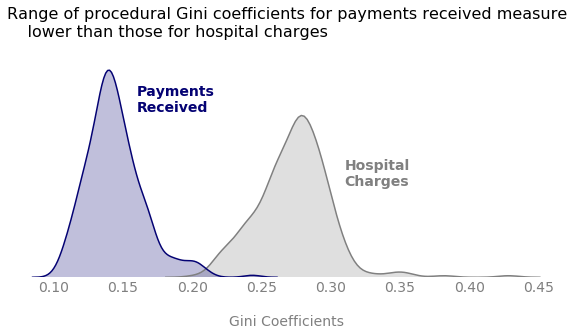

In [41]:
plt.figure(figsize=(10,4))
sns.kdeplot(gini_health.gini_charges.sort_values(), shade=True, color='gray')
sns.kdeplot(gini_health.gini_payments.sort_values(), shade=True, color='xkcd:deep blue')

plt.title('Range of procedural Gini coefficients for payments received measure\n    lower than those for hospital charges\n', 
          loc='left',fontsize=16)
plt.xlabel('Gini Coefficients', fontsize=14, color='gray', labelpad=20)

#Annotate
plt.text(.16, 18, 'Payments\nReceived', fontsize=14, color="xkcd:deep blue", fontweight='bold')
plt.text(.31, 10, 'Hospital\nCharges', fontsize=14, color='gray', fontweight='bold')

#Style
ax = plt.gca()
ax.set_frame_on(False)
ax.tick_params(axis=u'both', which=u'both',length=0, colors='gray', labelsize=14)
plt.yticks([])
plt.legend([], frameon=False);